In [1]:
from bw2data import Database, Method
import bw2data as bd
import brightway2 as bw
from premise import IncrementalDatabase
from polyviz import sankey

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import textwrap
import math

In [2]:
from functions_db import * # this is a python file with self-created functions needed to run this notebook
from config import * #some main key parameters needed.
from private_keys import * #import premise key

# decide to generate a incremental database to show premise's contributions:
GEN_SCENARIO_DB=False

In [3]:
bw.projects.set_current(PROJECT_NAME) #Creating/accessing the project
DB_NAME_INIT,PROJECT_NAME

('ecoinvent-3.10-cutoff', 'iea_h2_lca')

In [4]:
all_ei_databases = [db_2 for db_2 in bw.databases if "ecoinvent_" in str(db_2)]
#all_ei_databases = all_ei_databases[3:] + all_ei_databases[:3]
all_ei_databases

['ecoinvent_310_reference',
 'ecoinvent_remind_SSP2-PkBudg1150_2030_base',
 'ecoinvent_remind_SSP2-PkBudg1150_2035_base',
 'ecoinvent_remind_SSP2-PkBudg1150_2040_base',
 'ecoinvent_image_SSP2-RCP26_2030_base',
 'ecoinvent_image_SSP2-RCP26_2035_base',
 'ecoinvent_image_SSP2-RCP26_2040_base']

In [5]:
assess_year = 2040

if GEN_SCENARIO_DB:
    ndb = IncrementalDatabase(
        scenarios=[
                {"model": "remind", "pathway": "SSP2-PkBudg1150", "year": assess_year},
            ],
        source_db=DB_NAME_INIT, # <-- name of the database in the BW2 project. Must be a string.
        source_version=EI_VERSION, # <-- version of ecoinvent. Can be "3.5", "3.6", "3.7" or "3.8". Must be a string.
        key=KEY_PREMISE,
        biosphere_name=BIOSPHERE_DB,
        additional_inventories=[
            {"filepath": r"data\H2-DRI_LCI.xlsx", "ecoinvent version": "3.9.1"},
            {"filepath": r"data\BF-BOF-CCS_Carina.xlsx", "ecoinvent version": "3.9.1"},
            {"filepath": r"data\lci_biofuels_oil.xlsx", "ecoinvent version": EI_VERSION}]
    )

    sectors = {
        "electricity": "electricity",
        "steel": "steel",
        "cement": "cement",
        "fuels": "fuels",
        "others": [
            "cars",
            #"fuels",
            "trucks",
            "battery",
            "biomass",
            "dac",
            "heat",
            "emissions",
            "two_wheelers",
            "buses",
            "trains"
        ]
    }
    
    ndb.update(sectors=sectors)
    ndb.write_increment_db_to_brightway(name=f"Incremental_db_remind_SSP2-PkBudg1150_{assess_year}", file_format="csv")

## Instructions for importing and further analyzing scenario data

1. **Locate the File**  
   Navigate to the following folder to find the exported file:  
   `export\scenario diff files`

2. **Import the Scenario File**  
   - Open the **Activity Browser**.
   - Choose **'scenario'** as the *Calculation Setup*.
   - Select all **hydrogen applications** of interest.

3. **Run the Calculation**  
   - Execute the calculation to view the **contributions of the sectors**.

4. **Export and Use the Results**  
   - Export the results to an **Excel file**.
   - This exported data is then read and used for further analysis below.

### Make nicer plots of contributions of sectors of each hydrogen application, instead of using the graphs from Activity Browser

In [6]:
df_raw = pd.read_excel("export\scenario diff files\overview_scenario_diff_results.xlsx")
df_raw 

,method,"EF v3.1 EN15804, climate change, global warming potential (GWP100) including H2",Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,scenario,original,remind - SSP2-PkBudg1150... + electricity - 2040,remind - SSP2-PkBudg1150... + steel - 2040,remind - SSP2-PkBudg1150... + cement - 2040,remind - SSP2-PkBudg1150... + fuels - 2040,"remind - SSP2-PkBudg1150... + ['cars', 'trucks..."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fossil fuel | fossil fuel | GLO | Increm\nenta...,0.989649,0.909816,0.901413,0.901174,0.895684,0.896018
3,"ammonia, anhydrous, liquid | ammonia\nproducti...",4.106212,0.396514,0.378654,0.376944,0.596152,0.601321
4,"methanol, unpurified | methanol\nsynthesis, hy...",2.158765,-0.531291,-0.549898,-0.552452,-0.708057,-0.66659
5,"H2-DRI-EAF steel, low-alloyed | H2-DRI-\nEAF, ...",2.565802,1.414459,1.405277,1.401824,0.852778,0.877098
6,"heat | heat production, from hydrogen-\nfired ...",0.168856,0.015935,0.015193,0.01512,0.012775,0.012656
7,"transport, freight, lorry | transport,\nfreigh...",0.145605,0.112345,0.109381,0.109277,0.039832,0.039565
8,"electricity, high voltage | electricity\nprodu...",0.955279,0.08835,0.084187,0.083773,0.0705,0.069844
9,"heat, from residential heating system |\nheat,...",0.019985,0.017381,0.01728,0.017277,-0.000148,-0.000174


In [7]:
kg_co2_combustion_methanol_ms = 1.6904231625835189 #kgCO2/kg fuel, this was included in the fuel itself source from the atmosphere, so we use the same as emission to balance the carbon balance.
kg_co2_combustion_diesel_jf = 3.16 #kgCO2/kg fuel for both jet and diesel
burning_kg_ch4 = 2.74 #kgCO2/kgCH4

In [8]:
column_name_methanol = "Methanol (electrolytic hydrogen from power grid\n + DAC CO$_2$), incl. combustion"
column_name_synfuel = "Kerosene (Fischer-Tropsch, electrolytic hydrogen from power grid), incl. combustion"
column_name_methane = "Methane (electrochemical, atmospheric CO$_2$, electrolytic hydrogen from power grid), incl. combustion"

In [9]:
#Fix headers (row 0 as columns, drop row 1 which is NaN)
df = df_raw[2:].copy()
df.columns = df_raw.iloc[0]
df = df.dropna(how='all')

# Rename columns for clarity
df.columns.name = None
df = df.rename(columns={df.columns[0]: 'method'})

# Convert numeric columns to float
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Set method as index
df = df.set_index('method')
column_rename_dict = {
    df.columns[0]: "Reference (2025)",
    df.columns[1]: "Electricity (2040)",
    df.columns[2]: "Steel (2040)",
    df.columns[3]: "Cement (2040)",
    df.columns[4]: "Fuels (2040)",
    df.columns[5]: "Others (2040)"
}
df

,original,remind - SSP2-PkBudg1150... + electricity - 2040,remind - SSP2-PkBudg1150... + steel - 2040,remind - SSP2-PkBudg1150... + cement - 2040,remind - SSP2-PkBudg1150... + fuels - 2040,"remind - SSP2-PkBudg1150... + ['cars', 'trucks', 'battery', 'biomass', 'dac', 'heat', 'emissions', 'two_wheelers', 'buses', 'trains'] - 2040"
method,,,,,,
fossil fuel | fossil fuel | GLO | Increm\nental_db_remind_SSP2-PkBudg1150_2040,0.989649,0.909816,0.901413,0.901174,0.895684,0.896018
"ammonia, anhydrous, liquid | ammonia\nproduction, hydrogen from electrolysis |\nGLO | Incremental_db_remind_SSP2-\nPkBudg1150_2040",4.106212,0.396514,0.378654,0.376944,0.596152,0.601321
"methanol, unpurified | methanol\nsynthesis, hydrogen from electrolysis,\nCO2 from DAC | RER | Incremental_db_remi\nnd_SSP2-PkBudg1150_2040",2.158765,-0.531291,-0.549898,-0.552452,-0.708057,-0.666590
"H2-DRI-EAF steel, low-alloyed | H2-DRI-\nEAF, steel production, low-alloyed | GLO\n| Incremental_db_remind_SSP2-\nPkBudg1150_2040",2.565802,1.414459,1.405277,1.401824,0.852778,0.877098
"heat | heat production, from hydrogen-\nfired one gigawatt gas turbine | RER | I\nncremental_db_remind_SSP2-\nPkBudg1150_2040",0.168856,0.015935,0.015193,0.015120,0.012775,0.012656
"transport, freight, lorry | transport,\nfreight, lorry, fuel cell electric, 32t\ngross weight, long haul | RER | Incremen\ntal_db_remind_SSP2-PkBudg1150_2040",0.145605,0.112345,0.109381,0.109277,0.039832,0.039565
"electricity, high voltage | electricity\nproduction, from hydrogen-fired one\ngigawatt gas turbine | RER | Incremental\n_db_remind_SSP2-PkBudg1150_2040",0.955279,0.088350,0.084187,0.083773,0.070500,0.069844
"heat, from residential heating system |\nheat, residential, by combustion of\nhydrogen using CHP, allocated by exergy,\ndistributed by pipeline, produced by\nElectrolysis, PEM using electricity from\ngrid | RER | Incremental_db_remind_SSP2-\nPkBudg1150_2040",0.019985,0.017381,0.017280,0.017277,-0.000148,-0.000174
"heat, from residential heating system |\nheat, residential, by combustion of\nhydrogen using boiler, distributed by\npipeline, produced by Electrolysis, PEM\nusing electricity from grid | RER | Incr\nemental_db_remind_SSP2-PkBudg1150_2040",0.090307,0.078386,0.077920,0.077907,-0.000754,-0.000874


In [10]:
index_rename_dict = {
    "fossil fuel | fossil fuel | GLO | Increm\nental_db_remind_SSP2-PkBudg1150_2040": "Fossil fuel (hydrogen from SMR)",
    "ammonia, anhydrous, liquid | ammonia\nproduction, hydrogen from electrolysis |\nGLO | Incremental_db_remind_SSP2-\nPkBudg1150_2040": "Ammonia (electrolytic hydrogen from power grid)",
    "methanol, unpurified | methanol\nsynthesis, hydrogen from electrolysis,\nCO2 from DAC | RER | Incremental_db_remi\nnd_SSP2-PkBudg1150_2040": column_name_methanol,
    "H2-DRI-EAF steel, low-alloyed | H2-DRI-\nEAF, steel production, low-alloyed | GLO\n| Incremental_db_remind_SSP2-\nPkBudg1150_2040": "Steel (H$_2$-DRI-EAF, hydrogen market)",
    "heat | heat production, from hydrogen-\nfired one gigawatt gas turbine | RER | I\nncremental_db_remind_SSP2-\nPkBudg1150_2040": "Heat, via hydrogen gas turbine (electrolytic hydrogen from power grid)",
    "transport, freight, lorry | transport,\nfreight, lorry, fuel cell electric, 32t\ngross weight, long haul | RER | Incremen\ntal_db_remind_SSP2-PkBudg1150_2040": "Freight transport, FCEV 32t (hydrogen market)",
    "electricity, high voltage | electricity\nproduction, from hydrogen-fired one\ngigawatt gas turbine | RER | Incremental\n_db_remind_SSP2-PkBudg1150_2040": "Electricity (turbine, electrolytic hydrogen from power grid)",
    "heat, from residential heating system |\nheat, residential, by combustion of\nhydrogen using CHP, allocated by exergy,\ndistributed by pipeline, produced by\nElectrolysis, PEM using electricity from\ngrid | RER | Incremental_db_remind_SSP2-\nPkBudg1150_2040": "Residential heat (CHP, hydrogen market)",
    "heat, from residential heating system |\nheat, residential, by combustion of\nhydrogen using boiler, distributed by\npipeline, produced by Electrolysis, PEM\nusing electricity from grid | RER | Incr\nemental_db_remind_SSP2-PkBudg1150_2040": "Residential heat (boiler, hydrogen market)",
    "biofuel, Neste NExBTL | biofuel, Neste\nNExBTL | GLO | Incremental_db_remind_SSP\n2-PkBudg1150_2040": "2nd generation biofuel (Neste NExBTL, hydrogen from SMR), incl. combustion",
    "kerosene, synthetic | kerosene\nproduction, synthetic, Fischer Tropsch\nprocess, hydrogen from electrolysis,\nenergy allocation | RER | Incremental_db\n_remind_SSP2-PkBudg1150_2040": column_name_synfuel,
    "methane, from electrochemical\nmethanation | methane, from\nelectrochemical methanation, with carbon\nfrom atmosphere | RER | Incremental_db_r\nemind_SSP2-PkBudg1150_2040": column_name_methane,
    "transport, passenger car, EURO-6 |\ntransport, passenger car, compressed\nelectrochemical gas, Medium, EURO-6 |\nRER | Incremental_db_remind_SSP2-\nPkBudg1150_2040": "Passenger car (Electrochemical gas, EURO-6, electrolytic hydrogen from power grid)",
}
df = df.rename(columns=column_rename_dict)
df = df.rename(index=index_rename_dict)
df.index.name = 'method'
new_order = ['Others (2040)', 'Fuels (2040)', 'Cement (2040)','Steel (2040)', 'Electricity (2040)', 'Reference (2025)']
df = df[new_order]

#consider burning fuel emissions:
df.loc[column_name_methanol] = df.loc[column_name_methanol] + kg_co2_combustion_methanol_ms
df.loc[column_name_synfuel] = df.loc[column_name_synfuel] + kg_co2_combustion_diesel_jf
df.loc[column_name_methane] = df.loc[column_name_methane] + burning_kg_ch4
df

,Others (2040),Fuels (2040),Cement (2040),Steel (2040),Electricity (2040),Reference (2025)
method,,,,,,
Fossil fuel (hydrogen from SMR),0.896018,0.895684,0.901174,0.901413,0.909816,0.989649
Ammonia (electrolytic hydrogen from power grid),0.601321,0.596152,0.376944,0.378654,0.396514,4.106212
"Methanol (electrolytic hydrogen from power grid\n + DAC CO$_2$), incl. combustion",1.023833,0.982366,1.137971,1.140525,1.159132,3.849188
"Steel (H$_2$-DRI-EAF, hydrogen market)",0.877098,0.852778,1.401824,1.405277,1.414459,2.565802
"Heat, via hydrogen gas turbine (electrolytic hydrogen from power grid)",0.012656,0.012775,0.015120,0.015193,0.015935,0.168856
"Freight transport, FCEV 32t (hydrogen market)",0.039565,0.039832,0.109277,0.109381,0.112345,0.145605
"Electricity (turbine, electrolytic hydrogen from power grid)",0.069844,0.070500,0.083773,0.084187,0.088350,0.955279
"Residential heat (CHP, hydrogen market)",-0.000174,-0.000148,0.017277,0.017280,0.017381,0.019985
"Residential heat (boiler, hydrogen market)",-0.000874,-0.000754,0.077907,0.077920,0.078386,0.090307


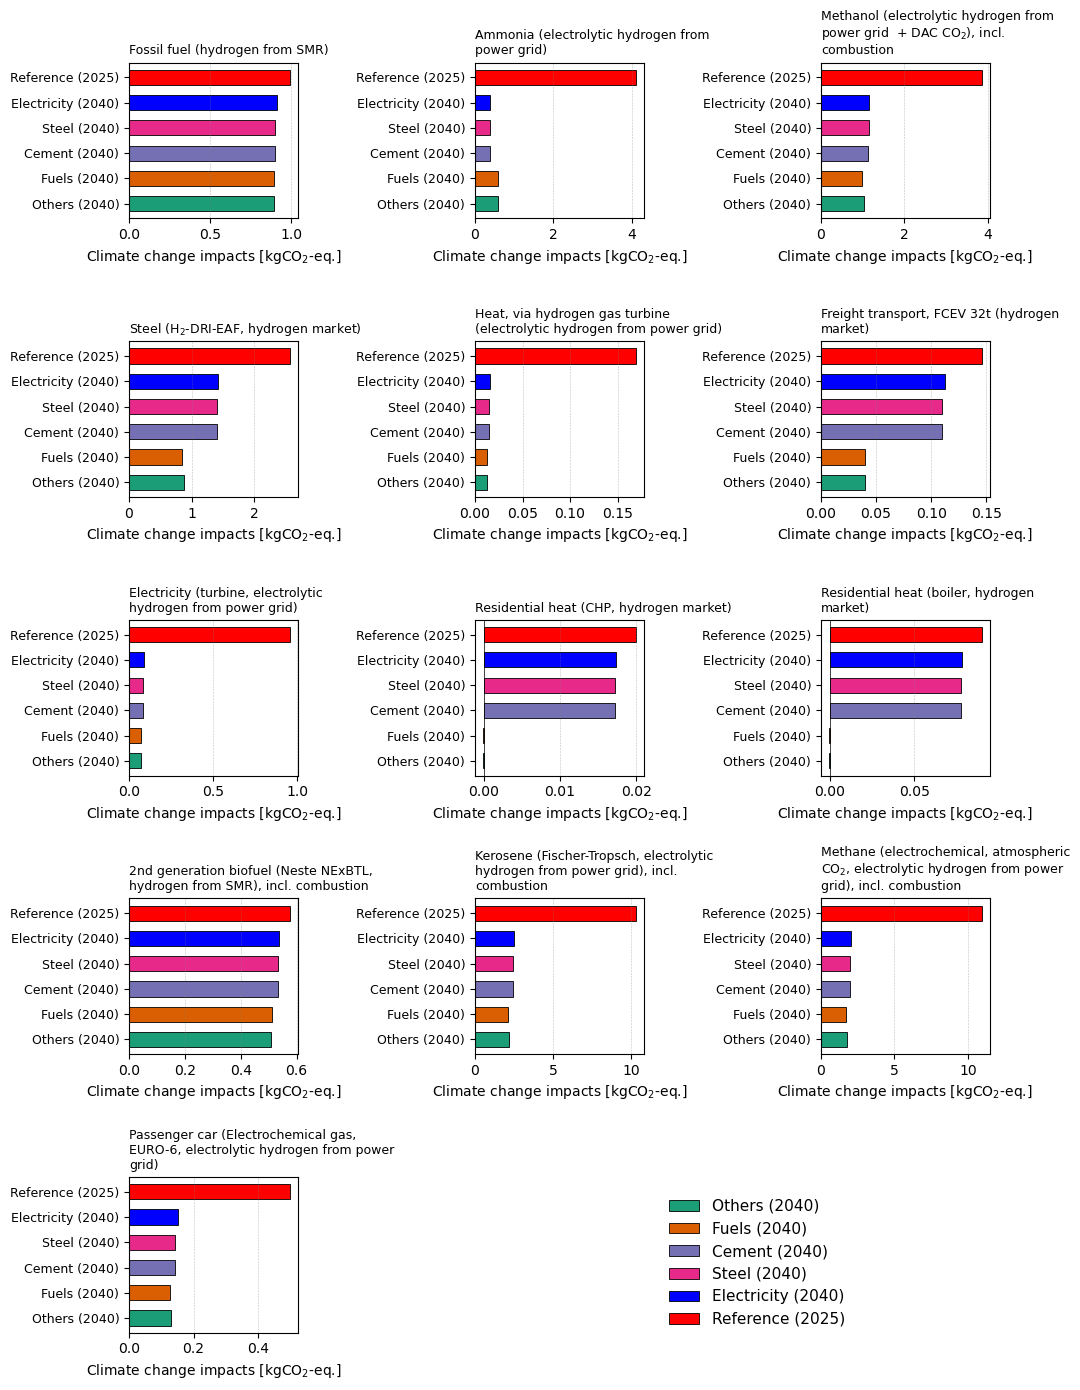

In [12]:
def wrap_labels(labels, width=40):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

# Input setup (assuming df is defined)
scenarios = df.columns
n_apps = len(df)
ncols = 3
nrows = math.ceil(n_apps / ncols)
bar_width = 0.6
colors = ['#1b9e77',  # Teal green (cool, professional)
          '#d95f02',  # Burnt orange (warm, good contrast)
          '#7570b3',  # Muted purple (balanced tone)
          '#e7298a',
          'blue',
         'red']  # Deep pink (eye-catching, distinct)
label_fontsize = 9

# Create grid of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 2.8))
axes = axes.flatten()

# Plot each application
for i, application in enumerate(df.index):
    ax = axes[i]
    for j, scenario in enumerate(scenarios):
        ax.barh(y=j, width=df.loc[application, scenario], height=bar_width,
                color=colors[j], edgecolor='black', linewidth=0.6,
                label=scenario if i == 0 else None)

    # Formatting
    ax.set_yticks(np.arange(len(scenarios)))
    ax.set_yticklabels([s.replace('_', ' ').capitalize() for s in scenarios], fontsize=label_fontsize)
    ax.set_title(wrap_labels([application])[0], fontsize=label_fontsize, loc='left')
    ax.axvline(0, color='black', linewidth=0.5)
    ax.grid(axis='x', linestyle='--', linewidth=0.4, color='grey', alpha=0.5)
    ax.tick_params(axis='y', labelsize=label_fontsize)
    ax.set_xlabel("Climate change impacts [kgCO$_2$-eq.]")

# Hide unused axes
for i in range(len(df), len(axes)):
    fig.delaxes(axes[i])

# Shared legend (outside)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,# title='Scenario', 
           title_fontsize=11, fontsize=11,
           loc='upper left', bbox_to_anchor=(0.55, 0.15), frameon=False)

# Layout
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.subplots_adjust(hspace=0.79, wspace=1.05)
plt.savefig("figs/applications_transformations_premise.png", dpi=200, bbox_inches='tight')
plt.show()

### Also, make beautiful Sankey diagrams for the applications

In [13]:
lca_acts_prod = pd.read_excel("data\LCA_act_overview.xlsx", sheet_name='h2_product', index_col = 'End use', nrows=17).fillna("nan")
for _, row in lca_acts_prod.iterrows():
    print(row['act_name'], row['act_loc'], row['ref_product'])


fossil fuel GLO fossil fuel
ammonia production, hydrogen from electrolysis GLO ammonia, anhydrous, liquid
methanol synthesis, hydrogen from electrolysis, CO2 from DAC incl. combustion RER methanol, unpurified
H2-DRI-EAF, steel production, low-alloyed, foreground changed GLO H2-DRI-EAF steel, low-alloyed
heat production, from hydrogen-fired one gigawatt gas turbine RER heat
transport, freight, lorry, fuel cell electric, 32t gross weight, long haul RER transport, freight, lorry
electricity production, from hydrogen-fired one gigawatt gas turbine RER electricity, high voltage
nan nan nan
heat, residential, by combustion of hydrogen using CHP, allocated by exergy, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid RER heat, from residential heating system
heat, residential, by combustion of hydrogen using boiler, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid RER heat, from residential heating system
biofuel, Neste NExBTL 

In [14]:
method = ('EF v3.1 EN15804', 'climate change', 'global warming potential (GWP100) including H2')
databases = [NAME_REF_DB, 'ecoinvent_remind_SSP2-PkBudg1150_2040_base']

for db_sel in databases:
    for _, row in lca_acts_prod.iterrows():
        print(row['act_name'], row['act_loc'])
    
        if (row['act_name'] == 'nan') or pd.isna(row['act_name']):
            print(f"Skipping row with missing data: {row['act_name']}")
            continue
            
        target_loc = row['act_loc'] if db_sel == NAME_REF_DB else row['act_loc_future']

        sel_act = [
            act for act in bd.Database(db_sel)
            if act['name'] == row['act_name']
            and act['location'] == target_loc
            and act['reference product'] == row['ref_product']
        ][0]
    
        sankey(
            activity=sel_act,
            level=5,
            cutoff=0.01,
            method=method,
            notebook=False,
            filepath=f"figs/sankeys/{db_sel} {sel_act['name'][:30]}.html"
        )

fossil fuel GLO
Calculating supply chain score...
Sankey diagram generated.
ammonia production, hydrogen from electrolysis GLO
Calculating supply chain score...
Sankey diagram generated.
methanol synthesis, hydrogen from electrolysis, CO2 from DAC incl. combustion RER
Calculating supply chain score...
Sankey diagram generated.
H2-DRI-EAF, steel production, low-alloyed, foreground changed GLO
Calculating supply chain score...
Sankey diagram generated.
heat production, from hydrogen-fired one gigawatt gas turbine RER
Calculating supply chain score...
Sankey diagram generated.
transport, freight, lorry, fuel cell electric, 32t gross weight, long haul RER
Calculating supply chain score...
Sankey diagram generated.
electricity production, from hydrogen-fired one gigawatt gas turbine RER
Calculating supply chain score...
Sankey diagram generated.
nan nan
Skipping row with missing data: nan
heat, residential, by combustion of hydrogen using CHP, allocated by exergy, distributed by pipeline, p